# Model Evaluation Notebook

This notebook evaluates the performance of the trained models. 
Results get stored in the /results folder.

class_metrics.csv contains the results of the per class analysis from each model and seed run.
class_metrics_agg.csv contains the results of the per class metrics aggregated.

moed_metrics.csv contains the results of the classification metrics from each model and seed run.
model_metrics_agg.csv contains the results of the classification metrics aggregated.

subgroup_metrics.csv contains the results of the subgroup analysis from each model and seed run.
subgroup_metrics_agg.csv contains the results of the subgroup metrics aggregated.


In [50]:
import os, gc
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torchvision import models, transforms, datasets
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from torch.utils.data import DataLoader
from pathlib import Path
import shutil
import matplotlib.pyplot as plt
import seaborn as sns

In [51]:
device = "cuda" if torch.cuda.is_available() else "cpu"


In [52]:
input_path1 = Path("../data/datasets/trashnet/")
input_path2 = Path("../data/datasets/trashvariety/")

In [53]:
#data transformations

eval_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])


source_ds = datasets.ImageFolder(input_path1 / "test",  transform= eval_tf)

target_ds = datasets.ImageFolder(input_path2, transform= eval_tf)

dataloader_source = DataLoader(
    source_ds,
    batch_size=32,
    shuffle=False,
    num_workers=4
)

dataloader_target = DataLoader(
    target_ds,
    batch_size=32,
    shuffle=False,
    num_workers=4
)

num_classes = len(target_ds.classes)


In [54]:
#Function to rebuild models for evaluation

def rebuild_model(filename: str, num_classes: int, device):
    
    if filename.startswith("resnet50"):
        m = models.resnet50(weights=None)
        m.fc = nn.Linear(m.fc.in_features, num_classes)

    elif filename.startswith("densenet121"):
        m = models.densenet121(weights=None)
        m.classifier = nn.Linear(m.classifier.in_features, num_classes)

    elif filename.startswith("convnext_tiny"):
        m = models.convnext_tiny(weights=None)
        m.classifier[2] = nn.Linear(m.classifier[2].in_features, num_classes)

    else:
        raise ValueError(f"Unknown architecture in filename: {filename}")

    return m.to(device)                            

In [55]:
#Function to calculate metrics

def evaluate_model_metrics(model, dataloader, device):
    model.eval()
    preds_list, labels_list = [], []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            preds_list.extend(preds.cpu().tolist())
            labels_list.extend(labels.cpu().tolist())

        return {
            "accuracy": accuracy_score(labels_list, preds_list),
            "macro_precision": precision_score(labels_list, preds_list, average="macro", zero_division=0),
            "macro_recall": recall_score(labels_list, preds_list, average="macro", zero_division=0),
            "macro_f1": f1_score(labels_list, preds_list, average="macro", zero_division=0),
            "n": len(labels_list),
        }

In [56]:
#Calculating metrics for all the models

cnn_models_dir = "../trained_models"
rows = []

for entry in sorted(os.listdir(cnn_models_dir)):
    if not entry.endswith(".pth"):
        continue

    ckpt_path = os.path.join(cnn_models_dir, entry)
    model_name = entry.replace(".pth", "")

    model = rebuild_model(entry, num_classes, device)

    ckpt = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(ckpt["model_state_dict"])

    src = evaluate_model_metrics(model, dataloader_source, device)
    tgt = evaluate_model_metrics(model, dataloader_target, device)

    rows.append({
        "model": model_name,

        "source_acc": src["accuracy"],
        "source_macro_precision": src["macro_precision"],
        "source_macro_recall": src["macro_recall"],
        "source_macro_f1": src["macro_f1"],

        "target_acc": tgt["accuracy"],
        "target_macro_precision": tgt["macro_precision"],
        "target_macro_recall": tgt["macro_recall"],
        "target_macro_f1": tgt["macro_f1"],

        "source_n": src["n"],
        "target_n": tgt["n"],
    })

    del model
    torch.cuda.empty_cache()

df = pd.DataFrame(rows)
metric_cols = [c for c in df.columns if c not in ["model", "source_n", "target_n"]]
df[metric_cols] = df[metric_cols].round(4)

df["macro_f1_drop"] = (df["source_macro_f1"] - df["target_macro_f1"]).round(4)

df.to_csv("../results/model_metrics.csv")

print("Results saved to /results/model_metrics.csv")    

Results saved to /results/model_metrics.csv


In [57]:
df = pd.read_csv("../results/model_metrics.csv")

def parse_model_name(name):
    parts = name.split('_')
    arch = parts[0]
    if arch == "resnet50": arch = "ResNet"
    if arch == "densenet121": arch = "DenseNet"
    if arch == "convnext": arch = "ConvNeXt"
    aug = "baseline"
    for a in ["geo", "photo", "mixed", "base", "baseline"]:
        if a in name:
            aug = a if a != "base" else "baseline"
    return arch, aug

df[["architecture", "augmentation"]] = df["model"].apply(lambda x: pd.Series(parse_model_name(x)))

grouped = df.groupby(["architecture", "augmentation"])
agg = grouped.agg({
    "source_acc": ["mean", "std"],
    "source_macro_precision": ["mean", "std"],
    "source_macro_recall": ["mean", "std"],
    "source_macro_f1": ["mean", "std"],
    "target_acc": ["mean", "std"],
    "target_macro_precision": ["mean", "std"],
    "target_macro_recall": ["mean", "std"],
    "target_macro_f1": ["mean", "std"],
    "macro_f1_drop": ["mean", "std"]
}).round(4)

agg.to_csv("../results/model_metrics_agg.csv")
print("Saved aggregated metrics to results/model_metrics_agg.csv")

Saved aggregated metrics to results/model_metrics_agg.csv


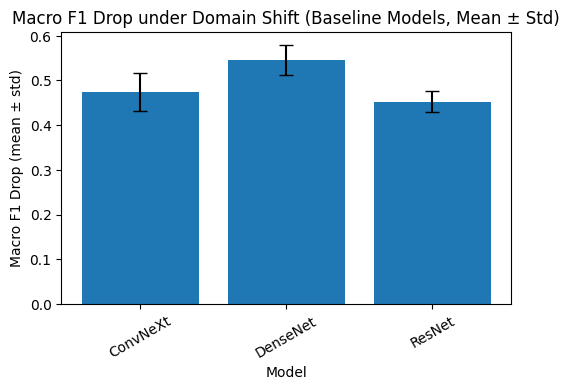

In [58]:
agg_baseline = agg.xs("baseline", level="augmentation")
plt.figure(figsize=(6, 4))
plt.bar(
    agg_baseline.index,
    agg_baseline["macro_f1_drop"]["mean"],
    yerr=agg_baseline["macro_f1_drop"]["std"],
    capsize=5
)
plt.title("Macro F1 Drop under Domain Shift (Baseline Models, Mean ± Std)")
plt.xlabel("Model")
plt.ylabel("Macro F1 Drop (mean ± std)")
plt.xticks(rotation=30)
plt.subplots_adjust(bottom=0.2, left=0.15)
plt.savefig("../images/MacroF1Baseline_MeanStd.png")
plt.show()

/tmp/ipykernel_1976160/1994642911.py:3: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  sns.barplot(


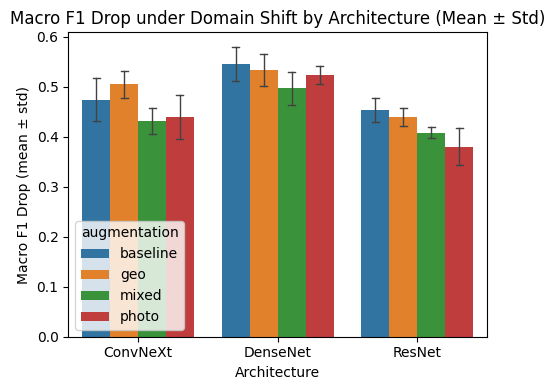

In [59]:
plt.figure(figsize=(5, 4))

sns.barplot(
    x="architecture",
    y="macro_f1_drop",
    data=df,
    hue="augmentation",
    errorbar="sd",
    capsize=0.2,
    errwidth=1,
)

plt.title("Macro F1 Drop under Domain Shift by Architecture (Mean ± Std)")
plt.xlabel("Architecture")
plt.ylabel("Macro F1 Drop (mean ± std)")
plt.tight_layout()
plt.savefig("../images/MarcoF1byArchitecture_MeanStd.png")
plt.show()

In [60]:
# funtion to buil folder structure for subgroup analysis
 
def build_subgroup_folder(
    csv_path,
    images_root,
    out_root,
    filter_col,
    filter_value,        
    class_col="class",
    id_col="id",
    overwrite=True,
    copy_files=True    
):
    csv_path = Path(csv_path)
    images_root = Path(images_root)
    out_root = Path(out_root)

    df = pd.read_csv(csv_path)

    sub = df[df[filter_col] == filter_value].copy()
    subgroup_name = f"{filter_col}_{filter_value}"
    dst_root = out_root / subgroup_name

    if overwrite and dst_root.exists():
        shutil.rmtree(dst_root)
    dst_root.mkdir(parents=True, exist_ok=True)

    missing = 0
    written = 0

    for _, row in sub.iterrows():
        cls = str(row[class_col]).strip()
        fname = str(row[id_col]).strip()

        src = images_root / cls / fname
        if not src.exists():
            missing += 1
            continue

        dst_class_dir = dst_root / cls
        dst_class_dir.mkdir(parents=True, exist_ok=True)
        dst = dst_class_dir / fname

        if copy_files:
            shutil.copy2(src, dst)
        else:
            if dst.exists():
                dst.unlink()
            dst.symlink_to(src.resolve())

        written += 1
        
    return dst_root


In [61]:
# buidling folder structure for subgroup analysis

csv_path = "../data/subgroups.csv"
images_root = input_path2
out_root = "../data/subgroups"

low_light_root = build_subgroup_folder(csv_path, images_root, out_root,
                                       filter_col="lighting", filter_value=2,
                                       copy_files=True)

good_light_root = build_subgroup_folder(csv_path, images_root, out_root,
                                        filter_col="lighting", filter_value=1,
                                        copy_files=True)

background_tree_root = build_subgroup_folder(csv_path, images_root, out_root,
                                       filter_col="background", filter_value="tree",
                                       copy_files=True)

background_wall_root = build_subgroup_folder(csv_path, images_root, out_root,
                                       filter_col="background", filter_value="wall",
                                       copy_files=True)

background_white_root = build_subgroup_folder(csv_path, images_root, out_root,
                                       filter_col="background", filter_value="white",
                                       copy_files=True)

background_floor_root = build_subgroup_folder(csv_path, images_root, out_root,
                                       filter_col="background", filter_value="floor",
                                       copy_files=True)  

near_view_root = build_subgroup_folder(csv_path, images_root, out_root,
                                       filter_col="view", filter_value=1,
                                       copy_files=True)

far_view_root = build_subgroup_folder(csv_path, images_root, out_root,
                                        filter_col="view", filter_value=2,
                                        copy_files=True)                                                                                                                   

In [62]:
# Evaluate all models on all subgroups

subgroups_root = Path("../data/subgroups")  
cnn_models_dir_path = Path(cnn_models_dir) 
rows = []

for entry in sorted(cnn_models_dir_path.iterdir()):
    if not entry.name.endswith(".pth"):
        continue

    model_name = entry.stem
    print(f"Evaluating model: {model_name} ...")

    model = rebuild_model(entry.name, num_classes, device)
    ckpt = torch.load(entry, map_location=device)
    model.load_state_dict(ckpt["model_state_dict"])

    model.eval()

    for sg_dir in sorted(subgroups_root.iterdir()):
        if not sg_dir.is_dir():
            continue

        ds = datasets.ImageFolder(sg_dir, transform=eval_tf)

        if len(ds) == 0:
            rows.append({
                "model": model_name,
                "subgroup": sg_dir.name,
                "accuracy": float("nan"),
                "macro_precision": float("nan"),
                "macro_recall": float("nan"),
                "macro_f1": float("nan"),
                "n": 0,
                "note": "empty subgroup"
            })
            continue

        loader = torch.utils.data.DataLoader(
            ds,
            batch_size=32,
            shuffle=False,
            num_workers=0 
        )

        metrics = evaluate_model_metrics(model, loader, device)

        rows.append({
            "model": model_name,
            "subgroup": sg_dir.name,
            "accuracy": metrics["accuracy"],
            "macro_precision": metrics["macro_precision"],
            "macro_recall": metrics["macro_recall"],
            "macro_f1": metrics["macro_f1"],
            "n": metrics["n"],
            "note": ""
        })

    del model
    torch.cuda.empty_cache()

df_subgroups = pd.DataFrame(rows)
metric_cols = [c for c in df_subgroups.columns if c not in ["model", "subgroup", "n", "note"]]
df_subgroups[metric_cols] = df_subgroups[metric_cols].round(4)

df_subgroups.to_csv("../results/subgroup_metrics.csv")

print("saved subgroup evaluation to: results/subgroup_metrics.csv")

Evaluating model: convnext_tiny_baseline_seed1024 ...
Evaluating model: convnext_tiny_baseline_seed128 ...
Evaluating model: convnext_tiny_baseline_seed256 ...
Evaluating model: convnext_tiny_baseline_seed512 ...
Evaluating model: convnext_tiny_baseline_seed64 ...
Evaluating model: convnext_tiny_geo_seed1024 ...
Evaluating model: convnext_tiny_geo_seed128 ...
Evaluating model: convnext_tiny_geo_seed256 ...
Evaluating model: convnext_tiny_geo_seed512 ...
Evaluating model: convnext_tiny_geo_seed64 ...
Evaluating model: convnext_tiny_mixed_seed1024 ...
Evaluating model: convnext_tiny_mixed_seed128 ...
Evaluating model: convnext_tiny_mixed_seed256 ...
Evaluating model: convnext_tiny_mixed_seed512 ...
Evaluating model: convnext_tiny_mixed_seed64 ...
Evaluating model: convnext_tiny_photo_seed1024 ...
Evaluating model: convnext_tiny_photo_seed128 ...
Evaluating model: convnext_tiny_photo_seed256 ...
Evaluating model: convnext_tiny_photo_seed512 ...
Evaluating model: convnext_tiny_photo_seed64

KeyboardInterrupt: 

In [ ]:
#Aggregate subgroup metrics (mean and std) across seeds
sub_df = pd.read_csv("../results/subgroup_metrics.csv")
sub_df[["architecture", "augmentation"]] = sub_df["model"].apply(lambda x: pd.Series(parse_model_name(x)))

# Group by architecture, augmentation, subgroup
subgroup_grouped = sub_df.groupby(["architecture", "augmentation", "subgroup"])
subgroup_agg = subgroup_grouped.agg({
    "accuracy": ["mean", "std"],
    "macro_precision": ["mean", "std"],
    "macro_recall": ["mean", "std"],
    "macro_f1": ["mean", "std"],
    "n": ["mean", "std"]
}).round(4)

subgroup_agg.to_csv("../results/subgroup_metrics_agg.csv")
print("Saved aggregated subgroup metrics to results/subgroup_metrics_agg.csv")

Saved aggregated subgroup metrics to results/subgroup_metrics_agg.csv

Aggregated subgroup macro F1 (first few rows):
                                           macro_f1        
                                               mean     std
architecture augmentation subgroup                         
ConvNeXt     baseline     background_floor   0.4357  0.0984
                          background_tree    0.3435  0.0395
                          background_wall    0.4335  0.0479
                          background_white   0.5459  0.0613
                          lighting_1         0.5275  0.0321
                          lighting_2         0.3625  0.0740
                          view_1             0.4846  0.0456
                          view_2             0.4214  0.0346
             geo          background_floor   0.4533  0.0540
                          background_tree    0.2488  0.0581
                          background_wall    0.4116  0.0598
                          background_white

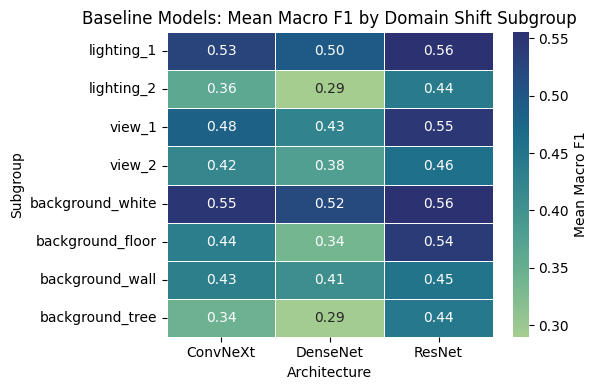

In [ ]:
# show mean macro F1 per subgroup and architecture
sub_df = pd.read_csv("../results/subgroup_metrics.csv")
sub_df[["architecture", "augmentation"]] = sub_df["model"].apply(lambda x: pd.Series(parse_model_name(x)))

heat = (sub_df[sub_df["augmentation"] == "baseline"]
        .groupby(["subgroup", "architecture"])["macro_f1"]
        .mean()
        .unstack())
order = ["lighting_1","lighting_2","view_1","view_2",
         "background_white","background_floor","background_wall","background_tree"]
heat = heat.reindex(order)

plt.figure(figsize=(6, 4))
sns.heatmap(
    heat,
    annot=True,
    fmt=".2f",
    cmap="crest",
    cbar_kws={"label": "Mean Macro F1"},
    linewidths=0.5,
    linecolor="white"
)
plt.title("Baseline Models: Mean Macro F1 by Domain Shift Subgroup")
plt.xlabel("Architecture")
plt.ylabel("Subgroup")
plt.tight_layout()
plt.savefig("../images/HeatmapSubgroups_Mean.png")
plt.show()

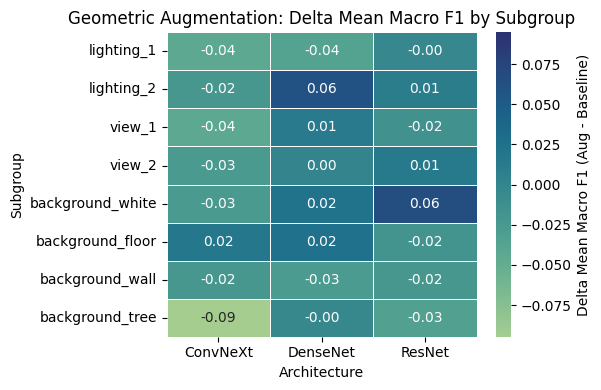

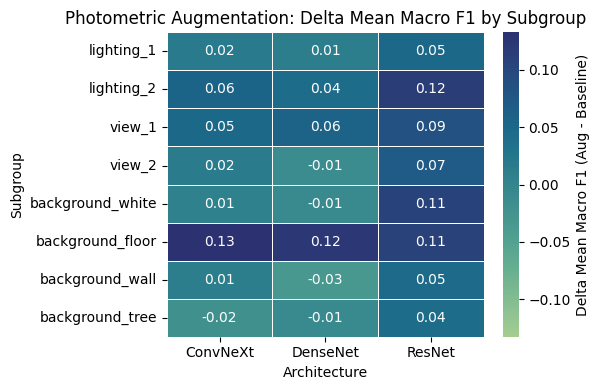

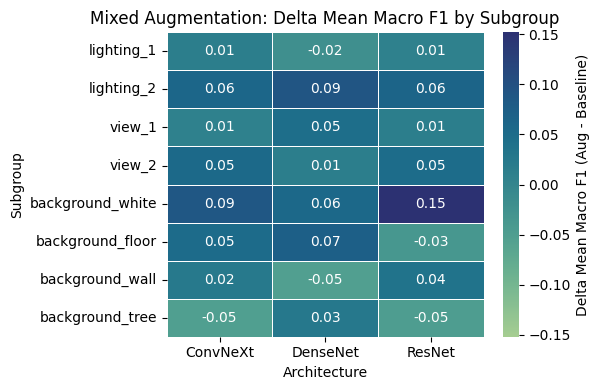

In [ ]:
# show mean delta macro F1 for each augmentation vs baseline
for aug in ["geometric", "photometric", "mixed"]:
    aug_map = {"geometric": "geo", "photometric": "photo", "mixed": "mixed"}
    aug_key = aug_map[aug]
    heat_aug = (sub_df[sub_df["augmentation"] == aug_key]
                .groupby(["subgroup", "architecture"])["macro_f1"]
                .mean()
                .unstack().reindex(order))
    heat_base = (sub_df[sub_df["augmentation"] == "baseline"]
                 .groupby(["subgroup", "architecture"])["macro_f1"]
                 .mean()
                 .unstack().reindex(order))
    delta = heat_aug - heat_base
    vmax = np.nanmax(np.abs(delta.values))
    plt.figure(figsize=(6, 4))
    sns.heatmap(
        delta,
        annot=True,
        fmt=".2f",
        center=0,
        vmin=-vmax, vmax=vmax,
        cmap="crest",
        linewidths=0.5,
        linecolor="white",
        cbar_kws={"label": "Delta Mean Macro F1 (Aug - Baseline)"}
    )
    plt.title(f"{aug.capitalize()} Augmentation: Delta Mean Macro F1 by Subgroup")
    plt.xlabel("Architecture")
    plt.ylabel("Subgroup")
    plt.tight_layout()
    plt.savefig(f"../images/delta_{aug}_heatmap_mean.png", dpi=300, bbox_inches="tight")
    plt.show()

In [ ]:
cnn_models_dir = "../trained_models"
class_names = target_ds.classes
rows = []

for fname in sorted(os.listdir(cnn_models_dir)):
    if not fname.endswith(".pth"):
        continue

    model_name = fname.replace(".pth", "")
    ckpt_path = os.path.join(cnn_models_dir, fname)

    model = rebuild_model(fname, num_classes, device)
    ckpt = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(ckpt["model_state_dict"])
    model.eval()

    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in dataloader_target:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            preds = outputs.argmax(dim=1)

            y_true.extend(labels.cpu().tolist())
            y_pred.extend(preds.cpu().tolist())

    report = classification_report(
        y_true, y_pred,
        target_names=class_names,
        output_dict=True,
        zero_division=0
    )

    for cls in class_names:
        rows.append({
            "model": model_name,
            "class": cls,
            "precision": report[cls]["precision"],
            "recall": report[cls]["recall"],
            "f1": report[cls]["f1-score"],
            "support": int(report[cls]["support"]),
        })

    del model, ckpt
    gc.collect()
    torch.cuda.empty_cache()

df_per_class = pd.DataFrame(rows)
df_per_class[["precision", "recall", "f1"]] = df_per_class[["precision", "recall", "f1"]].round(4)

df_per_class.to_csv("../results/class_metrics.csv")
print("saved class evaluation to: results/class_metrics.csv")

saved class evaluation to: results/class_metrics.csv


In [ ]:
# Aggregate per-class metrics (mean and std) across seeds

df_per_class = pd.read_csv("../results/class_metrics.csv")

def parse_model_name(name):
    parts = name.split('_')
    arch = parts[0]
    if arch == "resnet50": arch = "ResNet"
    if arch == "densenet121": arch = "DenseNet"
    if arch == "convnext": arch = "ConvNeXt"
    aug = "baseline"
    for a in ["geo", "photo", "mixed", "base", "baseline"]:
        if a in name:
            aug = a if a != "base" else "baseline"
    return arch, aug

df_per_class[["architecture", "augmentation"]] = df_per_class["model"].apply(lambda x: pd.Series(parse_model_name(x)))

class_grouped = df_per_class.groupby(["architecture", "augmentation", "class"])
class_agg = class_grouped.agg({
    "precision": ["mean", "std"],
    "recall": ["mean", "std"],
    "f1": ["mean", "std"],
    "support": ["mean", "std"]
}).round(4)

class_agg.to_csv("../results/class_metrics_agg.csv")
print("Saved per-class mean/std metrics to results/class_metrics_agg.csv")


Saved per-class mean/std metrics to results/class_metrics_agg.csv

Per-class mean/std F1 scores (first few rows):
                                         f1        
                                       mean     std
architecture augmentation class                    
ConvNeXt     baseline     cardboard  0.5072  0.0304
                          glass      0.5926  0.0489
                          metal      0.5083  0.0728
                          paper      0.3998  0.0280
                          plastic    0.4825  0.0586
                          trash      0.2346  0.1218
             geo          cardboard  0.4843  0.0358
                          glass      0.5018  0.1049
                          metal      0.4451  0.0488
                          paper      0.3963  0.0255
                          plastic    0.4488  0.0246
                          trash      0.2365  0.0842
